In [52]:
from numpy import *
import astropy.units as u
from astropy.constants import G, M_jup, R_jup, M_earth, R_earth, L_sun, M_sun, R_sun
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import scaling relation coefficients
rel = pd.read_csv('scalingrels2.csv')
rel.set_index('Tracer', inplace=True)

In [3]:
#line luminosity functions

def line_lum_distconv(line_lum_old, dist_old, dist_new):
    """
    Calculate the line luminosity at a distance
    given the line luminosity at another distance.
    
    """
    line_lum_new = line_lum_old * (dist_old**2)/(dist_new**2)
    return line_lum_new

def line_lum(line_flux, dist):
    """
    Calculate line luminosity given line flux and distance
    assuming line flux is extinction corrected.
    """
    #future: could add extinction correction in there? Not sure how that works.
    
    line_lum = 4 * pi * (dist*u.pc)**2 * line_flux * u.erg / (u.s * (u.cm)**2)
    line_lum = line_lum.decompose().to(u.W)
    return line_lum/u.W

In [4]:
def accr_lum(L_line, tracer, L_line_err = 0*u.W):
    """
    Translate a line luminosity to accretion luminosity using empirical
    relationships from Alcala et al. 2017.
    
    Included tracers are:
    'H_alpha'
    'H_beta'
    'H_gamma'
    'H_delta'
    'H_epsilon'
    'Pa_beta'
    'Pa_gamma'
    'He_I_587.6'
    'He_I_667.8'
    'Ca_II_K'
    'Ca_II_H'
    'Ca_II_866.2'
    """
        
    a, a_err, b, b_err = rel['a'][tracer],rel['a_err'][tracer],rel['b'][tracer],rel['b_err'][tracer]
    
    log_L_acc = b + a * log10(L_line*u.W/L_sun)
    
    L_acc = 10**log_L_acc*L_sun
    
    #attempt at error propagation
    
    #c_err = (L_line_err)/(log(10) * L_line)
    #ac_err = a * log10(L_line/L_sun) * ((a_err/a)**2 + (c_err/log10(L_line/L_sun))**2)**0.5
    #log_L_acc_err = (b_err**2 + ac_err**2)**0.5
    #L_acc_err = L_acc * log(10) * log_L_acc_err

    return L_acc/u.W

In [5]:
def acc_rate(L_acc, R, M):
    """
    Translate an accretion luminosity and planet mass/radius to accretion rate in Solar masses per year.
    """
    mdot = 1.25*L_acc*u.W*R*u.R_sun/(G*M*u.M_sun)
    mdot = mdot.decompose().to(u.M_sun/u.yr)
    return(mdot/(u.M_sun/u.yr))

In [6]:
db = pd.read_csv('accdb_master_copy.csv')
db = db[(isnan(db['Object Radius R_solar'])==False) & (isnan(db['Object Mass M_Solar'])==False)]
db = db[['Source','Object Mass M_Solar','Object Radius R_solar','Ha Line Flux (erg/(s*cm^2)', 'Hb Line Flux (erg/(s*cm^2)',
       'Hgamma Line Flux (erg/(s*cm^2)', 'PaB Line Flux (erg/(s*cm^2)',
       'PaG Line Flux (erg/(s*cm^2)', 'BrG Line Flux (erg/(s*cm^2)',
       'He I 587.6 Line Flux (erg/(s*cm^2)',
       'He I 667.8 Line Flux (erg/(s*cm^2)', 'Ca II K Line Flux (erg/(s*cm^2)',
       'Ca II H Line Flux (erg/(s*cm^2)']]

In [7]:
tracers = ['Ha','Hb','Hgamma','PaB','PaG','BrG','He I 587.6','He I 667.8','Ca II K','Ca II H']

In [88]:
db['distances'] = ones(202)*150


db['Ha Line lum'] = zeros(202)
db['Hb Line lum'] = zeros(202)
db['Hgamma Line lum'] = zeros(202)
db['PaB Line lum'] = zeros(202)
db['PaG Line lum'] = zeros(202)
db['BrG Line lum'] = zeros(202)
db['He I 587.6 Line lum'] = zeros(202)
db['He I 667.8 Line lum'] = zeros(202)
db['Ca II K Line lum'] = zeros(202)
db['Ca II H Line lum'] = zeros(202)


db['Ha acc lum'] = zeros(202)
db['Hb acc lum'] = zeros(202)
db['Hgamma acc lum'] = zeros(202)
db['PaB acc lum'] = zeros(202)
db['PaG acc lum'] = zeros(202)
db['BrG acc lum'] = zeros(202)
db['He I 587.6 acc lum'] = zeros(202)
db['He I 667.8 acc lum'] = zeros(202)
db['Ca II K acc lum'] = zeros(202)
db['Ca II H acc lum'] = zeros(202)

db['Ha acc rate'] = zeros(202)
db['Hb acc rate'] = zeros(202)
db['Hgamma acc rate'] = zeros(202)
db['PaB acc rate'] = zeros(202)
db['PaG acc rate'] = zeros(202)
db['BrG acc rate'] = zeros(202)
db['He I 587.6 acc rate'] = zeros(202)
db['He I 667.8 acc rate'] = zeros(202)
db['Ca II K acc rate'] = zeros(202)
db['Ca II H acc rate'] = zeros(202)

db['acc rate'] = zeros(202)

In [89]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [90]:
for i in db.index:
    for t in tracers:
        if isnan(db[t + ' Line Flux (erg/(s*cm^2)'][i]) == False:
            db.at[i,t + ' Line lum'] = line_lum(db[t + ' Line Flux (erg/(s*cm^2)'][i], db['distances'][i])
            db.at[i,t + ' acc lum'] = accr_lum(db[t + ' Line lum'][i], t)
            db.at[i,t + ' acc rate'] = acc_rate(db[t + ' acc lum'][i], db['Object Radius R_solar'][i], db['Object Mass M_Solar'][i])


In [91]:
for i in db.index:
    count = 0
    for t in tracers:
        if db[t + ' acc rate'][i]!=0:
            db.loc[i,'acc rate'] += db[t + ' acc rate'][i]
            count += 1
    if count!=0:
        db.loc[i,'acc rate'] /= count

In [93]:
db = db.replace(0,nan)
r = db[['Source','Object Mass M_Solar','acc rate']]
r = r.dropna()

In [94]:
m = log10(r['Object Mass M_Solar'].tolist())
mdot = log10(r['acc rate'].tolist())

(-16, -5)

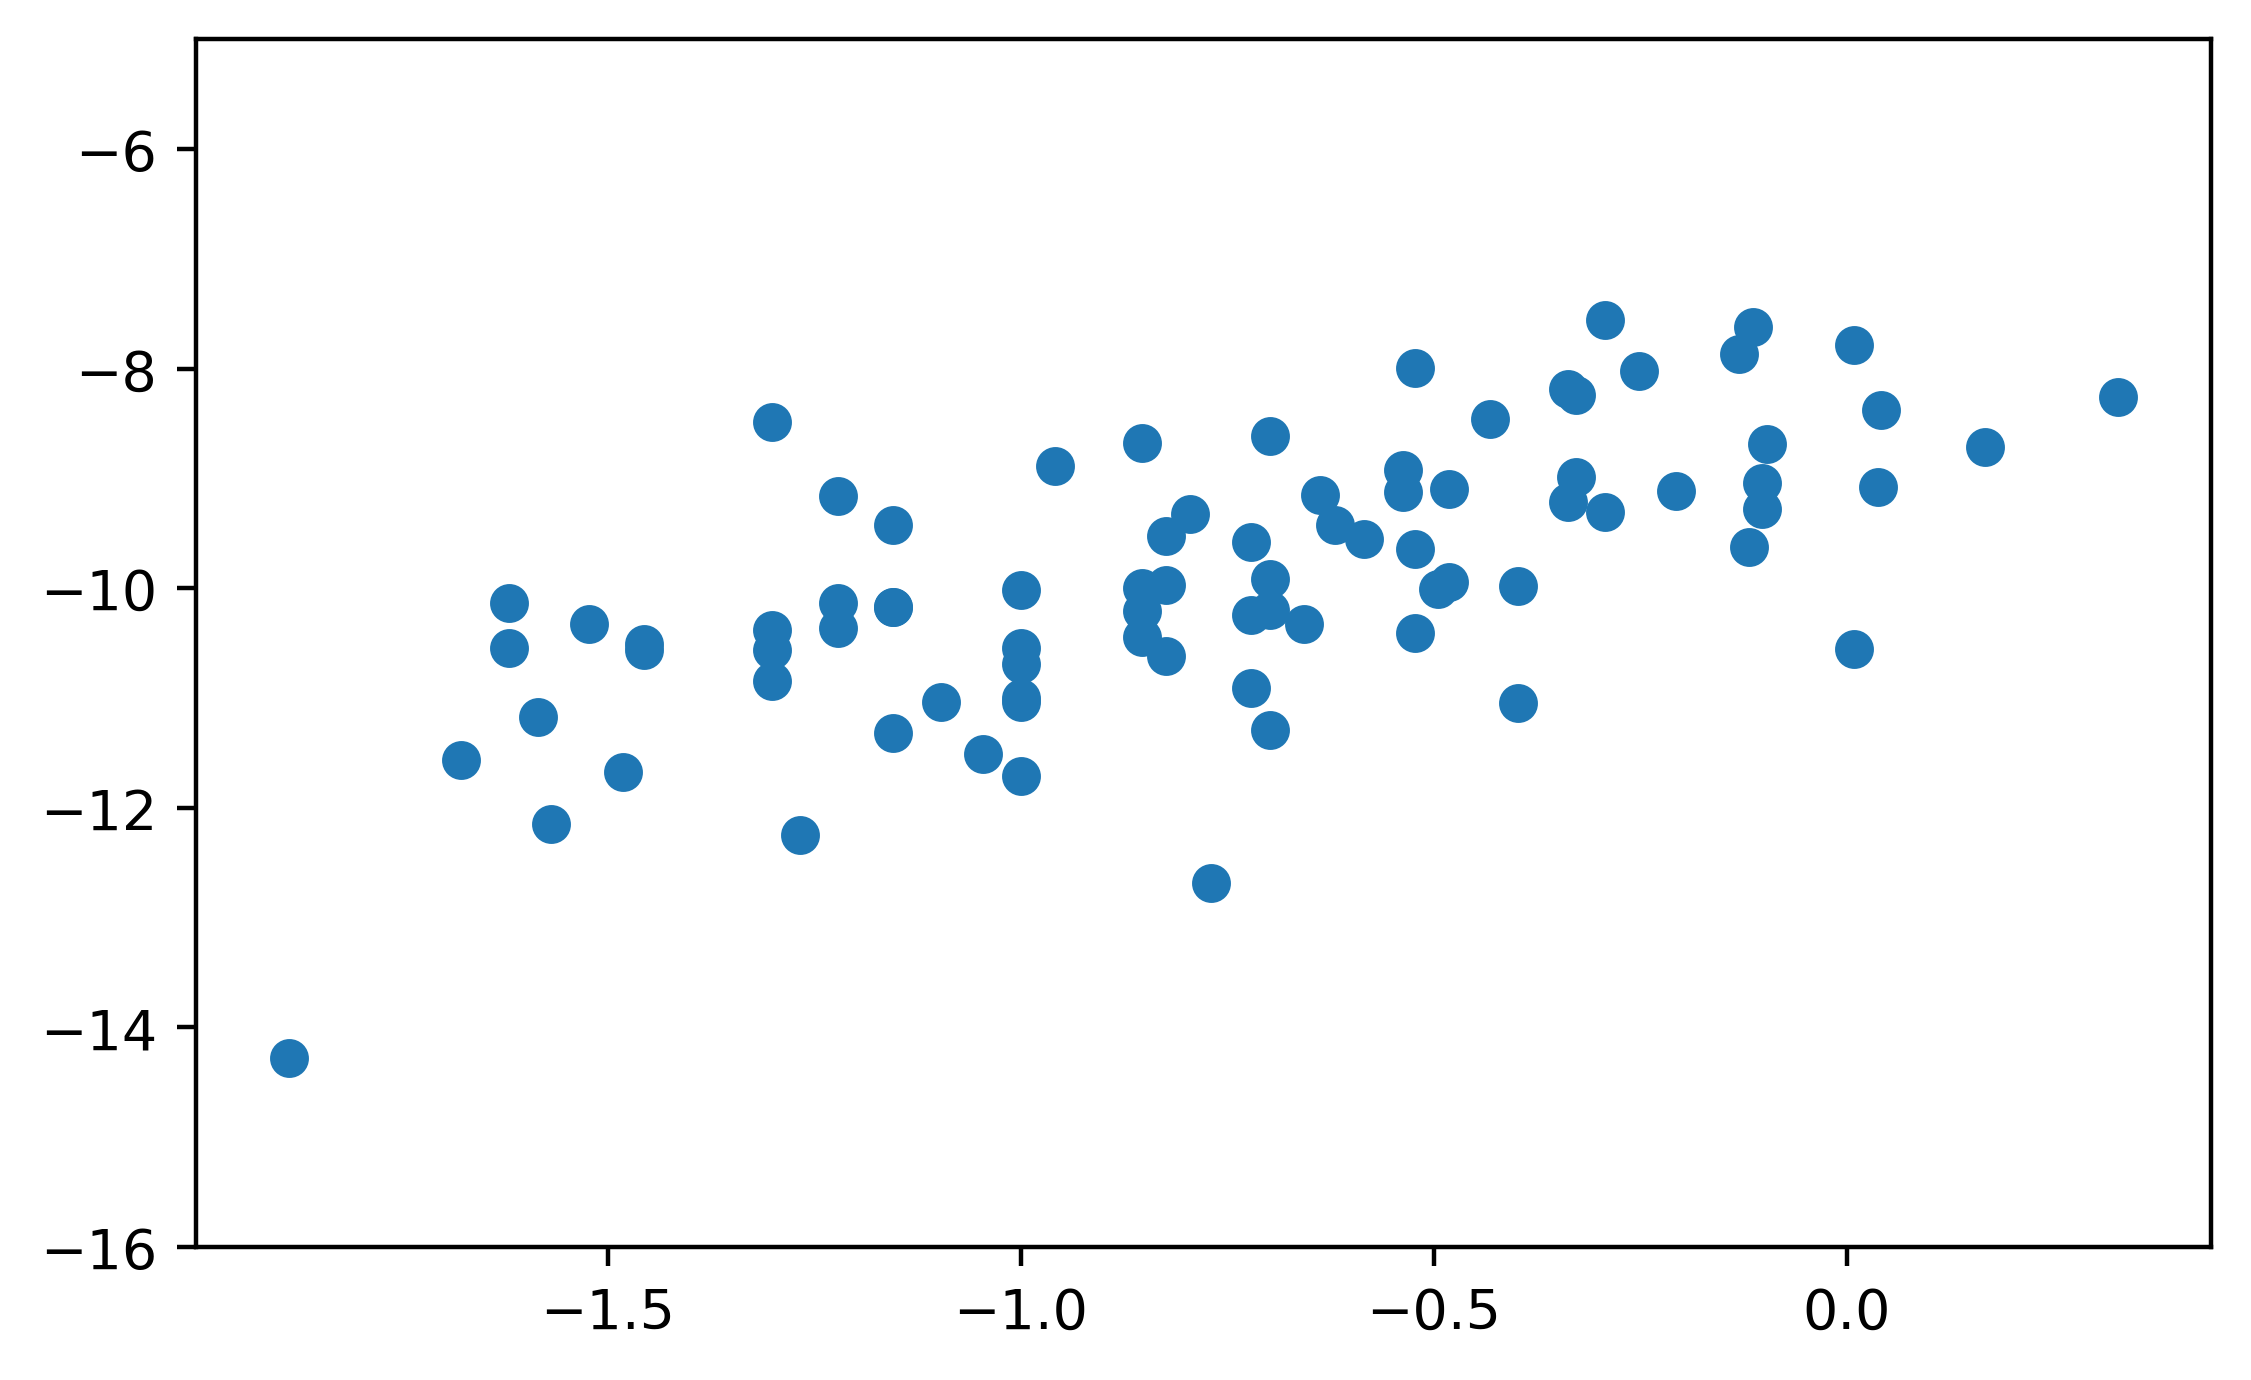

In [95]:
plt.figure(figsize = (6.5,4), dpi = 400)
plt.scatter(m,mdot)
plt.ylim(-16,-5)